In [1]:
import math
import numpy as np
from deap import base
from deap import creator
from deap import tools

import random

import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy.linalg import lu_factor, lu_solve

In [2]:
sys.path.append('../../examples/marine/pipelay_vessel_design_optimisation_using_genetic_algorithms/')

In [3]:
import elitism

### Finite Element Model of the Plane Truss structure

In [4]:
def PlaneTrussElementLength(x1,y1,x2,y2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1))

In [5]:
def PlaneTrussElementStiffness(E,A,L,theta):
    pi=3.14159265
    x = theta*pi/180
    C = math.cos(x)
    S = math.sin(x)
    return E*A/L*np.array([[C*C, C*S, -C*C, -C*S],[C*S, S*S, -C*S, -S*S],
                           [-C*C, -C*S, C*C, C*S],[-C*S, -S*S, C*S, S*S]]) 

In [6]:
def PlaneTrussAssemble(K,k,i,j):
    # K - np.array
    # k - np.array
    K[2*i,2*i] = K[2*i,2*i] + k[0,0]
    K[2*i,2*i+1] = K[2*i,2*i+1] + k[0,1] 
    K[2*i,2*j] = K[2*i,2*j] + k[0,2] 
    K[2*i,2*j+1] = K[2*i,2*j+1] + k[0,3]
    K[2*i+1,2*i] = K[2*i+1,2*i] + k[1,0]
    K[2*i+1,2*i+1] = K[2*i+1,2*i+1] + k[1,1] 
    K[2*i+1,2*j] = K[2*i+1,2*j] + k[1,2] 
    K[2*i+1,2*j+1] = K[2*i+1,2*j+1] + k[1,3] 
    K[2*j,2*i] = K[2*j,2*i] + k[2,0] 
    K[2*j,2*i+1] = K[2*j,2*i+1] + k[2,1]
    K[2*j,2*j] = K[2*j,2*j] + k[2,2]
    K[2*j,2*j+1] = K[2*j,2*j+1] + k[2,3] 
    K[2*j+1,2*i] = K[2*j+1,2*i] + k[3,0] 
    K[2*j+1,2*i+1] = K[2*j+1,2*i+1] + k[3,1]
    K[2*j+1,2*j] = K[2*j+1,2*j] + k[3,2] 
    K[2*j+1,2*j+1] = K[2*j+1,2*j+1] + k[3,3]
    
    return K 

In [7]:
def PlaneTrussElementForce(E,A,L,theta,u):
    pi=3.14159265
    x = theta* pi/180
    C = math.cos(x)
    S = math.sin(x)
    return E*A/L*np.dot(np.array([-C, -S, C, S]),u)

In [8]:
def PlaneTrussElementStress(E,L,theta,u):
    pi=3.14159265
    x = theta * pi/180
    C = math.cos(x)
    S = math.sin(x)
    return E/L*np.dot(np.array([-C, -S, C, S]),u)

In [9]:
def FEA_u(coord, elcon, bc_node, bc_val, global_force,  A=1e-4, E=210e6):
    K=np.zeros(shape=(2*np.max(elcon)+2,2*np.max(elcon)+2))
    for el in elcon:
        L=PlaneTrussElementLength(coord[el[0]][0],coord[el[0]][1],coord[el[1]][0],coord[el[1]][1])
        theta=math.atan((coord[el[1]][1]-coord[el[0]][1])/(coord[el[1]][0]-coord[el[0]][0]+1e-13))*180/math.pi
        k=PlaneTrussElementStiffness(E,A,L,theta)
        K=PlaneTrussAssemble(K,k,el[0],el[1])     
    
    F = global_force
    
    
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    
    bc=np.array([bc_node, 
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)

    s=np.linalg.lstsq(K[fdof,:][:,fdof],
                      (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, rcond=None)[0] 
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    
#     Q=np.dot(K,d).T-F 
    
    return d

In [10]:
# 5 The Plane Truss Element - verification 
d=FEA_u(np.array([0,0,
                  4,0,
                  2,3]).reshape(3,2), 
      elcon=np.array([[0, 1],
                      [0, 2],
                      [1, 2]]),
      bc_node = [0, 1, 3],
      bc_val = [0., 0., 0.],
      global_force = np.array([0,0,
                               0,0,
                               5,-10]),
      A=1e-4, 
      E=210e6)

In [11]:
d

array([ 0.        ,  0.        ,  0.00111111,  0.        ,  0.00195056,
       -0.00161037])

### Initial displacement 

In [12]:
coord=np.array([0.0,0.0,
                  2.0,3.0,
                  2.0,0.0,
                  5.0,3.0,
                  7.0,0.0,
                  9.0,3.0,
                  12.0,3.0,
                  12.0,0.0,
                  14.0,0.0]).reshape(9,2)

In [13]:
displ = FEA_u(coord.reshape(9,2),
              elcon=np.array([[0, 1],[0, 2],[1, 2],[1, 3],[2, 3],
                                                    [2, 4],[3, 4],[3, 5],[4, 5],[4, 7],
                                                    [5, 7],[5, 6],[6, 7],[6, 8],[7, 8]]),
                                                    bc_node=[0,1,
                                                             2,3,
                                                             12,13,
                                                             16,17],
                                                    bc_val=[0,0,
                                                            0,0,
                                                            0,0,
                                                            0,0],
                                                    global_force = np.array([0,0,
                                                                    0,0,
                                                                    0,0,
                                                                    0,0,
                                                                    0,-10,
                                                                    0,0,
                                                                    0,0,
                                                                    0,0,
                                                                    0,0]),
                                                    A=1e-4, E=210e6)

In [14]:
displ[9]

-0.005108382068326751

### Genetic Algorithm

In [15]:
BOUNDS_LOW =  [0, 2, 5, 5]
BOUNDS_HIGH = [5, 9, 12, 14]

In [16]:
NUM_OF_PARAMS = len(BOUNDS_HIGH)

In [17]:
# Genetic Algorithm constants:
POPULATION_SIZE = 250
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.5   # probability for mutating an individual
MAX_GENERATIONS = 50
HALL_OF_FAME_SIZE = 5
CROWDING_FACTOR = 20.0  # crowding factor for crossover and mutation

PENALTY_VALUE = 10.0    # fixed penalty for violating a constraint

# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

toolbox = base.Toolbox()

In [18]:
# define a single objective, maximize fitness strategy:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMax)


# define the hyperparameter attributes individually:
for i in range(NUM_OF_PARAMS):
    # "hyperparameter_0", "hyperparameter_1", ...
    toolbox.register("hyperparameter_" + str(i),
                     random.uniform,
                     BOUNDS_LOW[i],
                     BOUNDS_HIGH[i])

In [19]:
# create a tuple containing an attribute generator for each param searched:
hyperparameters = ()

for i in range(NUM_OF_PARAMS):
    hyperparameters = hyperparameters + (toolbox.__getattribute__("hyperparameter_" + str(i)),)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator",
                 tools.initCycle,
                 creator.Individual,
                 hyperparameters,
                 n=1)

In [20]:
# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [21]:
# fitness calculation
def femStatic(individual):
    x1=individual[0]
    x2=individual[1]
    x3=individual[2]
    x4=individual[3]

    
    coord=np.array([0.0,0.0,
                  2.0,3.0,
                  x1,0.0,
                  x2,3.0,
                  7.0,0.0,
                  x3,3.0,
                  12,3.0,
                  x4,0.0,
                  14.0,0.0]).reshape(9,2)
    
    displ = FEA_u(coord, 
              elcon=np.array([[0, 1],[0, 2],[1, 2],[1, 3],[2, 3],
                                                    [2, 4],[3, 4],[3, 5],[4, 5],[4, 7],
                                                    [5, 7],[5, 6],[6, 7],[6, 8],[7, 8]]),
                                                    bc_node=[0,1,
                                                             2,3,
                                                             12,13,
                                                             16,17],
                                                    bc_val=[0,0,
                                                            0,0,
                                                            0,0,
                                                            0,0],
                                                    global_force = np.array([0,0,
                                                                    0,0,
                                                                    0,0,
                                                                    0,0,
                                                                    0,-10,
                                                                    0,0,
                                                                    0,0,
                                                                    0,0,
                                                                    0,0]),
                                                    A=1e-4, E=210e6)
    return displ[9],

In [22]:
toolbox.register("evaluate", femStatic)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate",
                 tools.cxSimulatedBinaryBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR)

toolbox.register("mutate",
                 tools.mutPolynomialBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR,
                 indpb=1.0 / NUM_OF_PARAMS)


In [23]:
# Genetic Algorithm flow:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = elitism.eaSimpleWithElitism(population,
                                                      toolbox,
                                                      cxpb=P_CROSSOVER,
                                                      mutpb=P_MUTATION,
                                                      ngen=MAX_GENERATIONS,
                                                      stats=stats,
                                                      halloffame=hof,
                                                      verbose=True)


    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])

    print()
    print("Double check: ")
    
    
    x1 = best[0]  
    x2 = best[1]  
    x3 = best[2]  
    x4 = best[3]  

    
    g_coord=np.array([0.0,0.0,
                  2.0,3.0,
                  x1,0.0,
                  x2,3.0,
                  7.0,0.0,
                  x3,3.0,
                  12,3.0,
                  x4,0.0,
                  14.0,0.0]).reshape(9,2)
    


    displ = FEA_u(g_coord, elcon=np.array([[0, 1],[0, 2],[1, 2],[1, 3],[2, 3],
                                                    [2, 4],[3, 4],[3, 5],[4, 5],[4, 7],
                                                    [5, 7],[5, 6],[6, 7],[6, 8],[7, 8]]),
                                                    bc_node=[0,1,
                                                             2,3,
                                                             12,13,
                                                             16,17],
                                                    bc_val=[0,0,
                                                            0,0,
                                                            0,0,
                                                            0,0],
                                                    global_force = np.array([0,0,
                                                                    0,0,
                                                                    0,0,
                                                                    0,0,
                                                                    0,-10,
                                                                    0,0,
                                                                    0,0,
                                                                    0,0,
                                                                    0,0]),
                                                    A=1e-4, E=210e6)


    print("displ", displ[9], )
    
    # extract statistics:
    maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(maxFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Max/ Average Fitness')
    plt.title('Max and Average fitness over Generations')
    plt.savefig("gen.png")
    plt.show()
    return g_coord

gen	nevals	max        	avg        
0  	250   	-0.00420027	-0.00771135
1  	232   	-0.00414543	-0.00630386
2  	238   	-0.00413287	-0.0055875 
3  	236   	-0.0040402 	-0.00500441
4  	230   	-0.0040402 	-0.00464433
5  	235   	-0.00404002	-0.0043877 
6  	226   	-0.0040151 	-0.00426647
7  	231   	-0.00401484	-0.00420966
8  	229   	-0.00400305	-0.00415254
9  	230   	-0.00400305	-0.00411231
10 	229   	-0.00400305	-0.00408521
11 	234   	-0.00400302	-0.00407603
12 	231   	-0.00400132	-0.00406006
13 	232   	-0.0040013 	-0.00405226
14 	225   	-0.0040013 	-0.00403818
15 	236   	-0.00400127	-0.00403641
16 	233   	-0.00400041	-0.00403187
17 	235   	-0.00400039	-0.00403143
18 	238   	-0.00400037	-0.00403413
19 	240   	-0.00400037	-0.00403015
20 	236   	-0.00400034	-0.00403209
21 	236   	-0.00400028	-0.00402392
22 	222   	-0.00400028	-0.0040184 
23 	236   	-0.00400028	-0.00402475
24 	238   	-0.00400025	-0.00401621
25 	235   	-0.00400023	-0.00401654
26 	240   	-0.00400022	-0.00402126
27 	233   	-0.004000

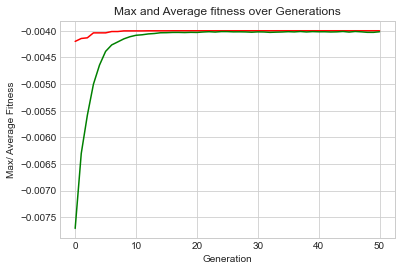

In [24]:
g_coord=main()

In [25]:
def draw(coord,color,elcon):
    coord=coord.reshape(np.max(elcon)+1,2)
    plt.figure(figsize=(13,5))
    for item in elcon:
        plt.plot([coord[item[0]][0],coord[item[1]][0]],
                 [coord[item[0]][1],coord[item[1]][1]],color=color)
        
    plt.show() 

### Initial Design 

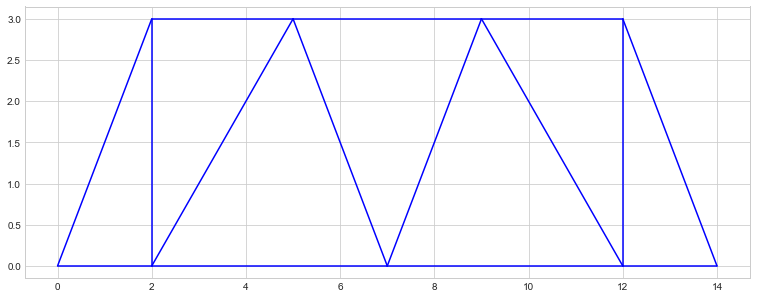

In [26]:
draw(coord,color="blue",elcon=np.array([[0, 1],[0, 2],[1, 2],[1, 3],[2, 3],
                                                    [2, 4],[3, 4],[3, 5],[4, 5],[4, 7],
                                                    [5, 7],[5, 6],[6, 7],[6, 8],[7, 8]]))

### Final Design

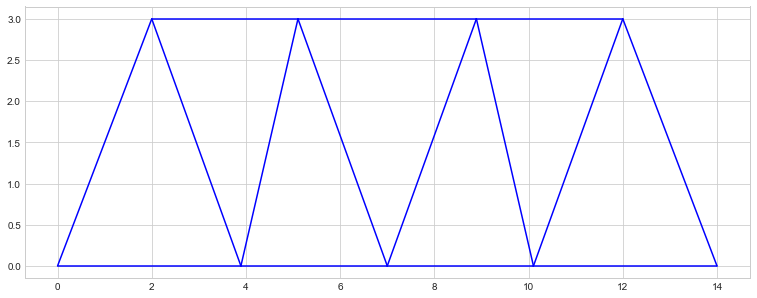

In [27]:
draw(g_coord,color="blue",elcon=np.array([[0, 1],[0, 2],[1, 2],[1, 3],[2, 3],
                                                    [2, 4],[3, 4],[3, 5],[4, 5],[4, 7],
                                                    [5, 7],[5, 6],[6, 7],[6, 8],[7, 8]]))

In [28]:
g_coord

array([[ 0.        ,  0.        ],
       [ 2.        ,  3.        ],
       [ 3.89262763,  0.        ],
       [ 5.10394232,  3.        ],
       [ 7.        ,  0.        ],
       [ 8.89205321,  3.        ],
       [12.        ,  3.        ],
       [10.10326825,  0.        ],
       [14.        ,  0.        ]])